In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [3]:
batch_size_train= 300
batch_size_test = 300
learning_rate = 0.001
momentum=0.5
n_epochs = 3

In [6]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [7]:
#Get the shape of train and test loaders

train_shape = enumerate(train_loader)
idx, (train_data, train_targets) = next(train_shape)

test_shape = enumerate(test_loader)
idx, (test_data, test_targets) = next(test_shape)

In [8]:
print('The shape of the train and test data are {} and {}train_data.shape'.format(train_data.shape, test_data.shape))

The shape of the train and test data are torch.Size([300, 1, 28, 28]) and torch.Size([300, 1, 28, 28])train_data.shape


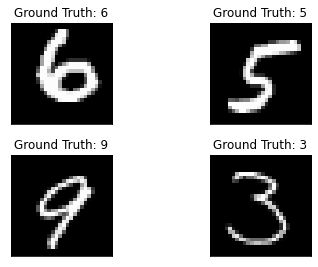

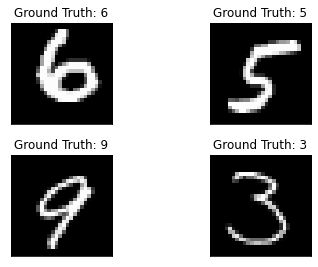

In [10]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

<Figure size 432x288 with 0 Axes>

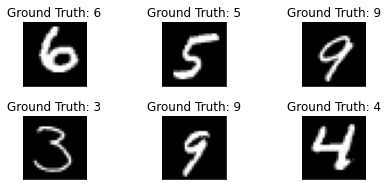

<Figure size 432x288 with 0 Axes>

In [11]:
num_plot = 6 #Make even number
for i in range(num_plot):
  plt.subplot(round(num_plot/2), round(num_plot/2), i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray')
  plt.title('Ground Truth: {}'.format(train_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.figure()

In [12]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    self.fc2 = nn.Linear(1000, 10)
  
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    #print(f"output shape: {out.shape}")
    return out



In [13]:
device  = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device used is {}".format(device))
model = ConvNet()
model.to(device) # send model to device/GPU for training 

Device used is cpu


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
num_epochs = 3

In [16]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #Run the forward pass
    # images = images.cuda()
    # label = labels.cuda()
    images, labels = next(iter(train_loader))    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # outputs = outputs.to(device)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i + 1) % 100 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                      (correct / total) * 100))

Epoch [1/3], Step [100/200], Loss: 0.0867, Accuracy: 97.00%
Epoch [1/3], Step [200/200], Loss: 0.0714, Accuracy: 97.67%
Epoch [2/3], Step [100/200], Loss: 0.0666, Accuracy: 98.33%
Epoch [2/3], Step [200/200], Loss: 0.0503, Accuracy: 99.00%
Epoch [3/3], Step [100/200], Loss: 0.1069, Accuracy: 97.33%
Epoch [3/3], Step [200/200], Loss: 0.0350, Accuracy: 98.33%


In [19]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot


Test Accuracy of the model on the 10000 test images: 100.0 %
Test Accuracy of the model on the 10000 test images: 99.16666666666667 %
Test Accuracy of the model on the 10000 test images: 99.11111111111111 %
Test Accuracy of the model on the 10000 test images: 99.0 %
Test Accuracy of the model on the 10000 test images: 99.06666666666666 %
Test Accuracy of the model on the 10000 test images: 99.05555555555556 %
Test Accuracy of the model on the 10000 test images: 98.95238095238095 %
Test Accuracy of the model on the 10000 test images: 99.0 %
Test Accuracy of the model on the 10000 test images: 99.03703703703704 %
Test Accuracy of the model on the 10000 test images: 99.06666666666666 %
Test Accuracy of the model on the 10000 test images: 99.06060606060606 %
Test Accuracy of the model on the 10000 test images: 99.08333333333333 %
Test Accuracy of the model on the 10000 test images: 99.05128205128206 %
Test Accuracy of the model on the 10000 test images: 99.0 %
Test Accuracy of the model on

In [29]:
model_save_name = 'model.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/{model_save_name}" 
torch.save(model.state_dict(), path)

In [31]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/model.pth'))
model

In [32]:
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')

p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}

p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')

p.line(np.arange(len(loss_list)), loss_list)

p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')

show(p)

In [ ]:
x.sum().item

<function Tensor.item>